## Install python packages

In [2]:
!pip install numpy tensorflow keras matplotlib pydot python-dotenv

-----

## Load environment variables

In [1]:
import os
from dotenv import load_dotenv

In [2]:
load_dotenv()

True

-----

## Install graphviz (for linux)

In [3]:
USE_SUDO = os.getenv('USE_SUDO')

bash_command = "apt-get install graphviz -y"

if USE_SUDO:
    SUDO_PASSWORD = os.getenv('SUDO_PASSWORD')
    
    bash_command = "echo {sudo_password} | sudo -S {command}".format(sudo_password = SUDO_PASSWORD, command = bash_command)
    
!{bash_command}

"sudo" no se reconoce como un comando interno o externo,
programa o archivo por lotes ejecutable.


-----

## Import libraries

In [74]:
%matplotlib inline

from os import path
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from tensorflow import keras
from keras.layers import InputLayer, BatchNormalization, Conv2DTranspose, Dense, Reshape, ReLU, LeakyReLU, Conv2D, Flatten
from keras.models import Sequential
from keras.optimizers import Adam
from keras.utils import plot_model

True

-----

## Define constants

In [2]:
# Directories used for the jupyter notebook
DIRECTORY_PATHS = {}

# Create the directory paths
DIRECTORY_PATHS["models"] = path.join('.', 'models')
DIRECTORY_PATHS["models_architecture"] = path.join(DIRECTORY_PATHS["models"], 'architecture')
DIRECTORY_PATHS["models_results"] = path.join(DIRECTORY_PATHS["models"], 'results')

MODEL_ARCHITECTURE_DIRECTORY = DIRECTORY_PATHS["models_architecture"]
MODEL_RESULTS_DIRECTORY = DIRECTORY_PATHS["models_results"]

# Name of the used models in this jupyter notebook
MODEL_NAMES = {
    "generator": "Generator",
    "discriminator": "Discriminator",
    "dcgan": "DCGAN"
}

# Extension of the architecture files (used by plot_model)
EXTENSION = "pdf"

# Use to map the numeric label to categorical label
CATEGORICAL_LABELS = {
    0: 'airplane',
    1: 'automobile',
    2: 'bird',
    3: 'cat',
    4: 'deer',
    5: 'dog',
    6: 'frog',
    7: 'horse',
    8: 'ship',
    9: 'truck'
}

# Constants used to show images
NUM_ROWS = 5
NUM_COLUMNS = 5
PADDING = .2

# Constans used to get random sample
SAMPLE_SIZE = NUM_ROWS * NUM_COLUMNS

# Constants used to train the DCGAN
NUM_EPOCHS = 32
BATCH_SIZE = 64

# BACTH_SIZE = NUM_REAL_DATA_SAMPLE + NUM_FAKE_DATA_SAMPLE
NUM_REAL_DATA_SAMPLE = int(BATCH_SIZE / 2)
NUM_FAKE_DATA_SAMPLE = NUM_REAL_DATA_SAMPLE

-----

## Create directories

In [3]:
for directory in DIRECTORY_PATHS.values():
    if not path.isdir(directory):
        os.mkdir(directory)

-----

## Define functions

In [4]:
def normalize_image(unnormalized_image):
    return (unnormalized_image / 127.5) - 1.0

def unnormalize_image(normalized_image):
    return (127.5 * (1.0 + normalized_image)).astype(int)
    
def get_model_architecture_file(base_path, file_name, extension):
    full_file_name = "{file_name}.{extension}".format(file_name = file_name, extension = extension)
    return path.join(base_path, full_file_name)

def get_random_sample(images, labels, sample_size):
    len_images = len(images)
    len_labels = len(labels)
    if len_images == len_labels:
        sample_indices = np.random.permutation(len_images)
        sample_indices = sample_indices[:sample_size]
        return images[sample_indices], labels[sample_indices]

def get_categorical_labels(labels, categorical_labels):
    labels = labels.copy().flatten()
    if isinstance(categorical_labels, dict):
        return [categorical_labels[label] for label in labels]
    
def get_images(images, labels=None, num_rows=1, num_columns=1, padding=.2, title = None):
    fig, ax = plt.subplots(num_rows, num_columns)
    fig.tight_layout(pad=padding)
    
    subplots = ax.flatten() if isinstance(ax, np.ndarray) else [ax]
    num_subplots = len(subplots)

    if title:
        fig.suptitle(title, y = 1.1)
    
    for i in range(num_subplots):
        subplot = subplots[i]
        image = images[i]
        
        subplot.axis("off")
        subplot.imshow(images[i])
        
        if labels:
            label = labels[i]
            subplot.set_title(labels[i])
    
    return fig

-----

## Datasets

### Load dataset

In [5]:
(x_train, y_train), (x_test, y_test) = keras.datasets.cifar10.load_data()

### A. Train data

#### Obtain data sample

In [6]:
sample_x_train, sample_y_train = get_random_sample(x_train, y_train, SAMPLE_SIZE)

#### Obtain categorical labels

In [7]:
sample_categorical_y_train = get_categorical_labels(sample_y_train, CATEGORICAL_LABELS)

#### Show images

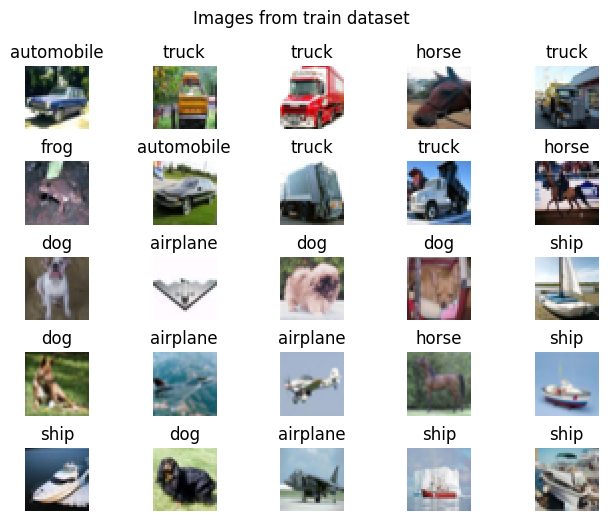

In [8]:
get_images(sample_x_train, sample_categorical_y_train, num_rows=NUM_ROWS, num_columns = NUM_COLUMNS, padding = PADDING, title="Images from train dataset");

### B. Test data

#### Obtain data sample

In [9]:
sample_x_test, sample_y_test = get_random_sample(x_test, y_test, SAMPLE_SIZE)

#### Obtain categorical labels

In [10]:
sample_categorical_y_test = get_categorical_labels(sample_y_test, CATEGORICAL_LABELS)

#### Show images

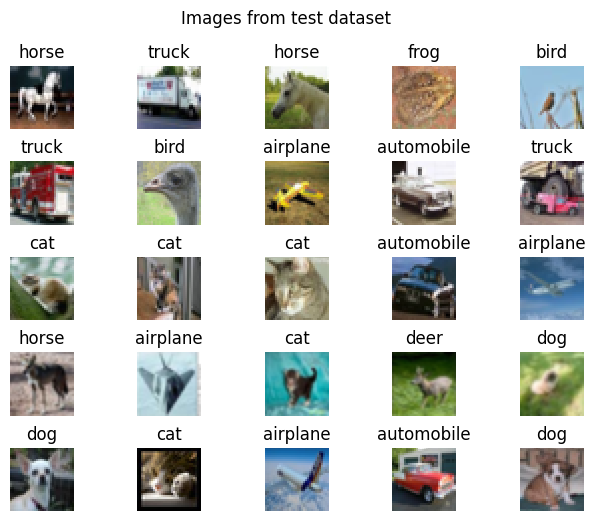

In [11]:
get_images(sample_x_test, sample_categorical_y_test, num_rows = NUM_ROWS, num_columns = NUM_COLUMNS, padding = PADDING, title="Images from test dataset");

-----

## Generator model

In [50]:
def build_generator(input_shape):
    generator = Sequential()

    generator.add(InputLayer(shape = input_shape))
    generator.add(Dense(4 * 4 * 1024))
    generator.add(ReLU())
    generator.add(BatchNormalization())
    generator.add(Reshape((4, 4, 1024)))

    generator.add(Conv2DTranspose(256, kernel_size = 3, strides = 2, padding = "same"))
    generator.add(ReLU())
    generator.add(BatchNormalization())

    generator.add(Conv2DTranspose(128, kernel_size = 3, strides = 2, padding = "same"))
    generator.add(ReLU())
    generator.add(BatchNormalization())

    generator.add(Conv2DTranspose(3, kernel_size = 3, strides = 2, padding = "same", activation="tanh"))

    generator.compile(run_eagerly = True)
    
    generator.summary()

    return generator

### Obtain the path to save the architecture file

In [51]:
GENERATOR_MODEL_ARCHITECTURE_FILE = get_model_architecture_file(MODEL_ARCHITECTURE_DIRECTORY, MODEL_NAMES["generator"], EXTENSION)

### Build generator

In [52]:
generator_input_shape = (100,)

generator = build_generator(generator_input_shape)

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_3 (Dense)                      │ (None, 16384)               │       1,654,784 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ re_lu_3 (ReLU)                       │ (None, 16384)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_9                │ (None, 16384)               │          65,536 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ reshape_1 (Reshape)                  │ (None, 4, 4, 1024)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose_3 (Conv2DTranspose) │ (None, 8, 8, 256)           │       2,359,552 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ re_lu_4 (ReLU)                       │ (None, 8, 8, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_10               │ (None, 8, 8, 256)           │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose_4 (Conv2DTranspose) │ (None, 16, 16, 128)         │         295,040 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ re_lu_5 (ReLU)                       │ (None, 16, 16, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_11               │ (None, 16, 16, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose_5 (Conv2DTranspose) │ (None, 32, 32, 3)           │           3,459 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 4,379,907 (16.71 MB)

 Trainable params: 4,346,371 (16.58 MB)

 Non-trainable params: 33,536 (131.00 KB)

### Save the plot model

In [ ]:
plot_model(generator, to_file = GENERATOR_MODEL_ARCHITECTURE_FILE, show_shapes = True, show_layer_names = True)

### Create random input to generate images

In [15]:
random_input = np.random.rand(NUM_ROWS * NUM_COLUMNS, 100)

### Print shape

In [16]:
print(random_input.shape)

(25, 100)


### Use the generator to create new images

In [17]:
result = [unnormalize_image(normalized_image) for normalized_image in generator.predict(random_input)]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 198ms/step


### Show the images

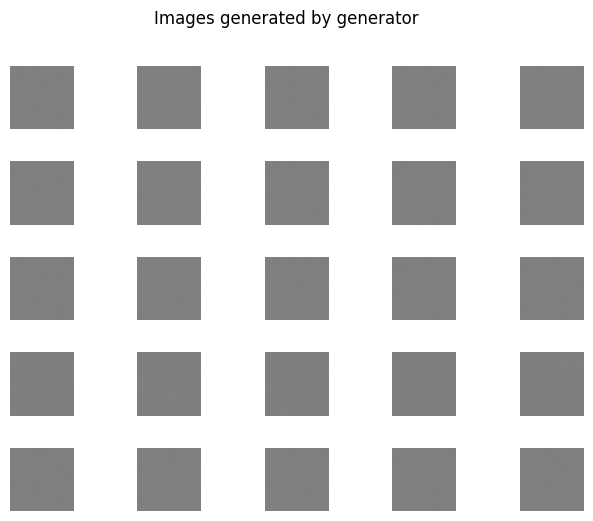

In [18]:
get_images(result, num_rows = NUM_ROWS, num_columns = NUM_COLUMNS, padding = PADDING, title = "Images generated by generator");

-----

## Discriminator model

In [53]:
def build_discriminator(input_shape):
    discriminator = Sequential()

    discriminator.add(Conv2D(128, input_shape = input_shape, kernel_size = 3, strides = 2, padding = "same"))
    discriminator.add(LeakyReLU())
    discriminator.add(BatchNormalization())

    discriminator.add(Conv2D(256, kernel_size = 3, strides = 2, padding = "same"))
    discriminator.add(LeakyReLU())
    discriminator.add(BatchNormalization())

    discriminator.add(Conv2D(1024, kernel_size = 3, strides = 2, padding = "same"))
    discriminator.add(LeakyReLU())
    discriminator.add(BatchNormalization())
    
    discriminator.add(Flatten())
    discriminator.add(Dense(1, activation = "sigmoid"))

    optimizer = Adam(learning_rate = 0.01)

    discriminator.compile(optimizer = optimizer, loss = "binary_crossentropy", metrics = ["accuracy"])

    discriminator.summary()

    return discriminator

### Obtain the path to save the architecture file

In [54]:
DISCRIMINATOR_MODEL_ARCHITECTURE_FILE = get_model_architecture_file(MODEL_ARCHITECTURE_DIRECTORY, MODEL_NAMES["discriminator"], EXTENSION)

### Build discriminator

In [55]:
discriminator_input_shape = (32, 32, 3, )

discriminator = build_discriminator(discriminator_input_shape)

Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_6 (Conv2D)                    │ (None, 16, 16, 128)         │           3,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_6 (LeakyReLU)            │ (None, 16, 16, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_12               │ (None, 16, 16, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_7 (Conv2D)                    │ (None, 8, 8, 256)           │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_7 (LeakyReLU)            │ (None, 8, 8, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_13               │ (None, 8, 8, 256)           │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_8 (Conv2D)                    │ (None, 4, 4, 1024)          │       2,360,320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_8 (LeakyReLU)            │ (None, 4, 4, 1024)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_14               │ (None, 4, 4, 1024)          │           4,096 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_2 (Flatten)                  │ (None, 16384)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 1)                   │          16,385 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,681,089 (10.23 MB)

 Trainable params: 2,678,273 (10.22 MB)

 Non-trainable params: 2,816 (11.00 KB)

### Save the plot model

In [ ]:
plot_model(discriminator, to_file = DISCRIMINATOR_MODEL_ARCHITECTURE_FILE, show_shapes = True, show_layer_names = True)

-----

## DCGAN model

In [56]:
def build_dcgan(generator, discriminator, input_shape = None):
    # The discriminator's weights are not trainnable when the dcgan is trained.
    discriminator.trainnable = False

    generator.name = "Generator"
    discriminator.name = "Discriminator"
    
    dcgan = Sequential()

    dcgan.add(InputLayer(shape = input_shape))  
    dcgan.add(generator)
    dcgan.add(discriminator)

    optimizer = Adam(learning_rate = 0.01)

    dcgan.compile(optimizer = optimizer, loss = "binary_crossentropy", metrics = ["accuracy"])

    dcgan.summary()
    
    return dcgan

### Obtain the path to save the architecture file

In [57]:
DCGAN_MODEL_ARCHITECTURE_FILE = get_model_architecture_file(MODEL_ARCHITECTURE_DIRECTORY, MODEL_NAMES["dcgan"], EXTENSION)

### Build DCGAN

In [58]:
dcgan = build_dcgan(generator, discriminator, input_shape = generator_input_shape)

Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ Generator (Sequential)               │ (None, 32, 32, 3)           │       4,379,907 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Discriminator (Sequential)           │ (None, 1)                   │       2,681,089 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 7,060,996 (26.94 MB)

 Trainable params: 7,024,644 (26.80 MB)

 Non-trainable params: 36,352 (142.00 KB)

### Save the plot model

In [ ]:
plot_model(dcgan, to_file = DCGAN_MODEL_ARCHITECTURE_FILE, show_shapes = True, show_layer_names = True)

-----

## Train DCGAN

### Define functions used to train dcgan

In [43]:
def get_real_image_dataset(images, batch_size = 32):
    images = tf.cast(images, dtype = tf.float32)
    dataset = tf.data.Dataset.from_tensor_slices(images).shuffle(1000).batch(batch_size, drop_remainder = True)
    dataset.map(normalize_image)
    return dataset

def get_discriminator_sample(fake_data, fake_labels, real_data, real_labels):
    train_data = tf.concat([fake_data, real_data], axis = 0)
    train_labels = tf.concat([fake_labels, real_labels], axis = 0)

    return train_data, train_labels

### Function used to train the DCGAN

In [71]:
@tf.function
def train(x_train, epochs = 32, num_real_data = 32, num_fake_data = 32, batch_size = 64, num_rows = 5, num_columns = 5):
    for epoch in range(1, epochs + 1):
        real_image_dataset = get_real_image_dataset(x_train, batch_size = NUM_REAL_DATA_SAMPLE)
        
        for real_images in real_image_dataset:
            # ----- Train discriminator -----
            
            # Generate noise by the generator to create a new images
            noise = tf.random.uniform(shape = [NUM_FAKE_DATA_SAMPLE, 100])

            # Generate the fake images and fake labels
            fake_images = tf.cast(generator(noise), dtype = tf.float32)
            fake_labels = tf.zeros([NUM_FAKE_DATA_SAMPLE, 1], dtype = tf.float32)
            
            # Generate the real labels
            real_labels = tf.ones([NUM_REAL_DATA_SAMPLE, 1], dtype = tf.float32)
            
            # Combine the fake and real images and fake and real labels
            discriminator_train_data, discriminator_train_labels = get_discriminator_sample(fake_images, fake_labels, real_images, real_labels)
            
            # First train the discriminator
            discriminator.train_on_batch(discriminator_train_data, discriminator_train_labels)
            
            # ----- Train the dcgan -----
        
            # Generate new noise
            dcgan_train_data = tf.constant(tf.random.uniform(shape = [BATCH_SIZE, 100]), dtype = tf.float32)
            
            # The label is changed to deceive to discriminator, equivalent to maximize log(D(G(z))). See https://pytorch.org/tutorials/beginner/dcgan_faces_tutorial.html
            dcgan_train_labels = tf.ones([BATCH_SIZE, 1], dtype = np.float32)
            
            # Train dcgan
            dcgan.train_on_batch(dcgan_train_data, dcgan_train_labels)
    
        # ----- Show results -----
            
        # Generate new noise
        noise = tf.random.uniform(shape = [NUM_ROWS * NUM_COLUMNS, 100])
        
        new_images = tf.constant([unnormalize_image(normalized_image) for normalized_image in generator(noise)], dtype = tf.float32)
        
        # Save new images
        filename = path.join(MODEL_RESULTS_DIRECTORY, "result_in_epoch{num_epoch}.{extension}".format(num_epoch = epoch, extension = EXTENSION))
        
        plot_title = "Images generated by generator in the epochs: {epoch}".format(epoch = epoch)
        plot_images = get_images(new_images, num_rows = NUM_ROWS, num_columns = NUM_COLUMNS, padding = PADDING, title = plot_title)
    
        plot_images.savefig(filename)

### Train DCGAN

In [72]:
train(x_train, epochs = NUM_EPOCHS)

NotImplementedError: in user code:

    File "C:\Users\crisj\AppData\Local\Temp\ipykernel_32612\1927781662.py", line 23, in train  *
        discriminator.train_on_batch(discriminator_train_data, discriminator_train_labels)
    File "C:\Users\crisj\miniconda3\Lib\site-packages\keras\src\backend\tensorflow\trainer.py", line 541, in train_on_batch  **
        logs = tree.map_structure(lambda x: np.array(x), logs)
    File "C:\Users\crisj\miniconda3\Lib\site-packages\keras\src\tree\tree_api.py", line 148, in map_structure
        return tree_impl.map_structure(func, *structures)
    File "C:\Users\crisj\miniconda3\Lib\site-packages\keras\src\tree\optree_impl.py", line 79, in map_structure
        return optree.tree_map(
    File "C:\Users\crisj\miniconda3\Lib\site-packages\optree\ops.py", line 594, in tree_map
        return treespec.unflatten(map(func, *flat_args))
    File "C:\Users\crisj\miniconda3\Lib\site-packages\keras\src\backend\tensorflow\trainer.py", line 541, in <lambda>
        logs = tree.map_structure(lambda x: np.array(x), logs)

    NotImplementedError: Cannot convert a symbolic tf.Tensor (StatefulPartitionedCall:0) to a numpy array. This error may indicate that you're trying to pass a Tensor to a NumPy call, which is not supported.
